## Environment setup and data pre-processing

Columns in the CSV file: Index(['<DATE>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>', '<VOL>',
       '<SPREAD>'],
      dtype='object')
First few rows of the data:
        <DATE>   <OPEN>   <HIGH>    <LOW>  <CLOSE>  <TICKVOL>         <VOL>  \
0  2017.01.02  116.780  117.651  116.634  117.478      43827   37425258000   
1  2017.01.03  117.461  118.602  117.210  117.731     173432  147091435000   
2  2017.01.04  117.720  118.182  117.047  117.214     172525  141471272000   
3  2017.01.05  117.215  117.425  115.213  115.339     222906  153808965000   
4  2017.01.06  115.328  117.175  115.065  116.942     190299  135880459000   

   <SPREAD>  
0         0  
1         0  
2         0  
3         0  
4         0  
Columns after renaming: Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'vol', 'spread'], dtype='object')
Data after feature engineering:
                open     high      low    close  volume           vol  spread  \
timestamp                              

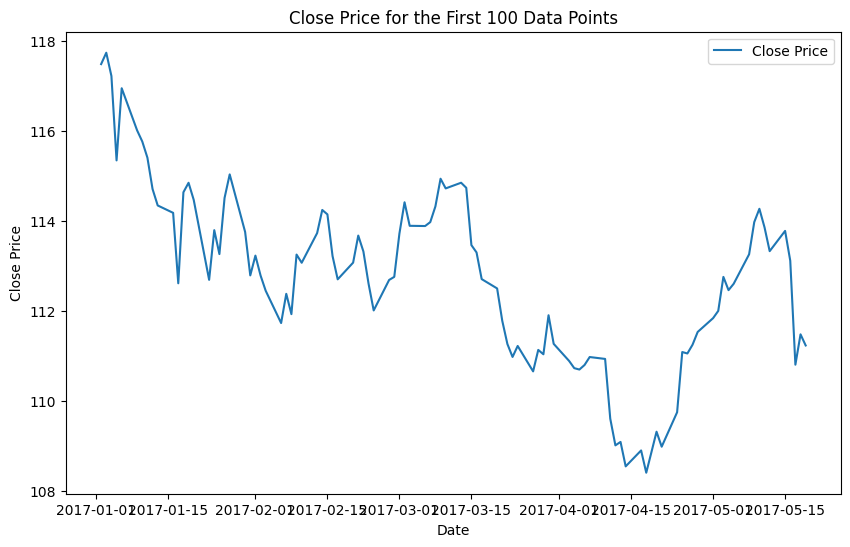

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the CSV file, assuming tab-separated values
df = pd.read_csv("USDJPY.csv", sep='\t')

# Print the column names and first few rows of the data for inspection
print("Columns in the CSV file:", df.columns)
print("First few rows of the data:\n", df.head())

# Rename the columns to meaningful names
df.rename(columns={'<DATE>': 'timestamp', 
                   '<OPEN>': 'open', 
                   '<HIGH>': 'high', 
                   '<LOW>': 'low', 
                   '<CLOSE>': 'close', 
                   '<TICKVOL>': 'volume', 
                   '<VOL>': 'vol', 
                   '<SPREAD>': 'spread'}, inplace=True)

# Print out columns to verify the renaming was successful
print("Columns after renaming:", df.columns)

# Convert the 'timestamp' column to datetime and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y.%m.%d')
df.set_index('timestamp', inplace=True)

# Convert all other columns to numeric (useful for columns like volume, spread, etc.)
df = df.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values (in case conversion to numeric introduced NaNs)
df.dropna(inplace=True)

# Add additional features based on the time and price data
df['hour'] = df.index.hour
df['day'] = df.index.weekday
df['week'] = df.index.isocalendar().week
df['momentum'] = df['volume'] * (df['open'] - df['close'])
df['avg_price'] = (df['low'] + df['high']) / 2
df['ohlc_price'] = (df['low'] + df['high'] + df['open'] + df['close']) / 4
df['oc_diff'] = df['open'] - df['close']

# Print the first few rows to see the additional features
print("Data after feature engineering:\n", df.head())

# Function to create the dataset for model input (creating X and y)
def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# Define target and feature column indices
target_index = df.columns.tolist().index('close')

# Scale the entire dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = df.values.astype('float32')
dataset = scaler.fit_transform(dataset)

# Create y_scaler to inverse transform later
y_scaler = MinMaxScaler(feature_range=(0, 1))
t_y = df['close'].values.astype('float32')
t_y = np.reshape(t_y, (-1, 1))
y_scaler = y_scaler.fit(t_y)

# Create X and y datasets
look_back = 50  # Time steps to look back for creating sequences
X, y = create_dataset(dataset, look_back=look_back)
y = y[:, target_index]

# Split the data into train and test sets (99% for training, 1% for testing)
train_size = int(len(X) * 0.99)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

# Display the shapes of the datasets
print("Train X shape:", trainX.shape)
print("Train Y shape:", trainY.shape)
print("Test X shape:", testX.shape)
print("Test Y shape:", testY.shape)

# Optional: Plot the first few rows of the close price
plt.figure(figsize=(10, 6))
plt.plot(df.index[:100], df['close'][:100], label='Close Price')
plt.title("Close Price for the First 100 Data Points")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()



## Model creation

In [50]:
model = Sequential()
model.add(GRU(50, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(GRU(50, return_sequences=True))
model.add(GRU(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

c:\Users\GaDiEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_28 (GRU)                    │ (None, 50, 50)         │         9,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_29 (GRU)                    │ (None, 50, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_30 (GRU)                    │ (None, 50, 10)         │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_31 (GRU)                    │ (None, 4)              │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,277 (106.55 KB)

 Trainable params: 27,277 (106.55 KB)

 Non-trainable params: 0 (0.00 B)

None


## Model Training

In [51]:
from keras.callbacks import ModelCheckpoint

# Train the model
checkpoint = ModelCheckpoint('best_model_weights.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Fit the model to the training data
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

# After training, load the best model weights
model.load_weights('best_model_weights.keras')

# Optionally print the training history (loss and validation loss over epochs)
print("Training Loss:", history.history['loss'][-1])
print("Validation Loss:", history.history['val_loss'][-1])


Epoch 1/50

Epoch 1: val_loss improved from inf to 0.46676, saving model to best_model_weights.keras
62/62 - 14s - 228ms/step - loss: 0.1419 - mae: 0.2595 - mse: 0.1419 - val_loss: 0.4668 - val_mae: 0.6828 - val_mse: 0.4668
Epoch 2/50

Epoch 2: val_loss improved from 0.46676 to 0.29002, saving model to best_model_weights.keras
62/62 - 3s - 52ms/step - loss: 0.0807 - mae: 0.2370 - mse: 0.0807 - val_loss: 0.2900 - val_mae: 0.5380 - val_mse: 0.2900
Epoch 3/50

Epoch 3: val_loss improved from 0.29002 to 0.04835, saving model to best_model_weights.keras
62/62 - 4s - 65ms/step - loss: 0.0312 - mae: 0.1136 - mse: 0.0312 - val_loss: 0.0484 - val_mae: 0.2186 - val_mse: 0.0484
Epoch 4/50

Epoch 4: val_loss improved from 0.04835 to 0.00591, saving model to best_model_weights.keras
62/62 - 4s - 65ms/step - loss: 0.0033 - mae: 0.0399 - mse: 0.0033 - val_loss: 0.0059 - val_mae: 0.0732 - val_mse: 0.0059
Epoch 5/50

Epoch 5: val_loss improved from 0.00591 to 0.00165, saving model to best_model_weights

## Benchmark

2024-11-30 01:36:07,619 : WARNING : 6 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002399A055300> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
DatetimeIndex(['2024-11-01', '2024-11-04', '2024-11-05', '2024-11-06',
               '2024-11-07', '2024-11-08', '2024-11-11', '2024-11-12',
               '2024-11-13', '2024-11-14', '2024-11-15', '2024-11-18',
               '2024-11-19', '2024-11-20', '2024-11-21', '2024-11-22',
               '2024-11-25', '2024-11-26', '2024-11-27', '2024-11-28',
               '2024-11-29'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


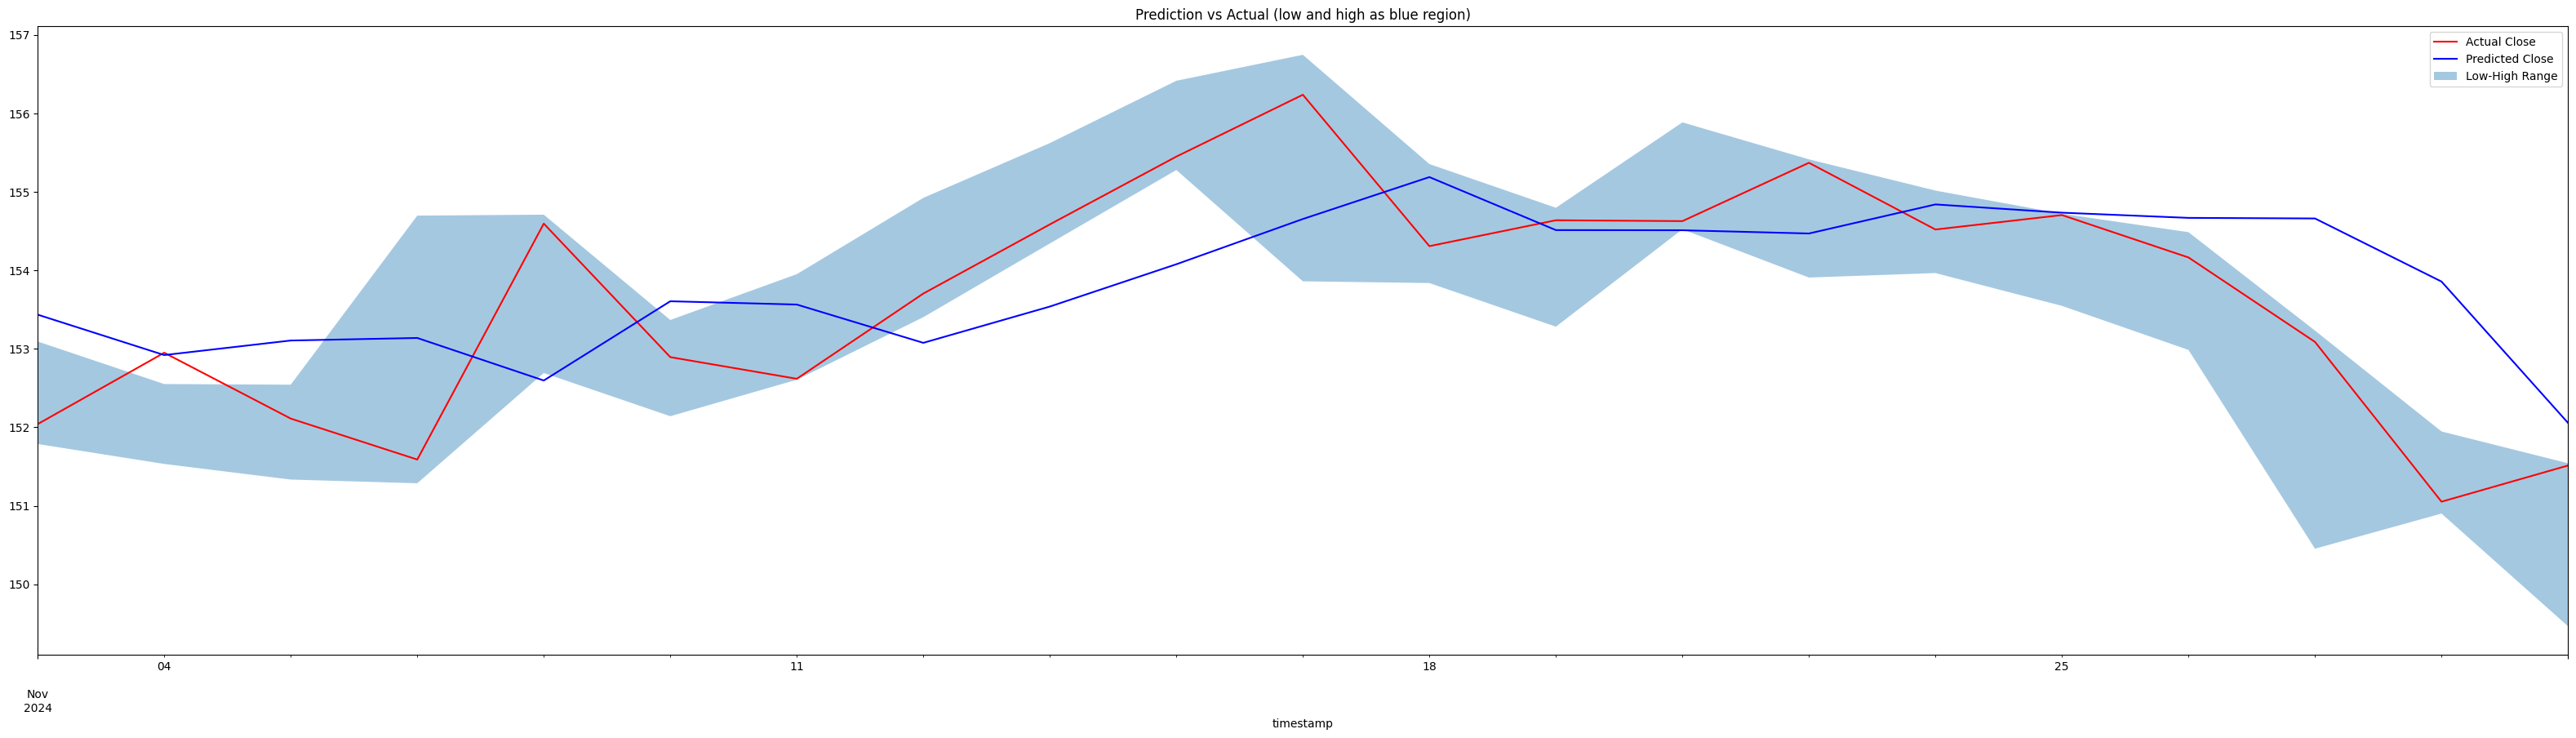

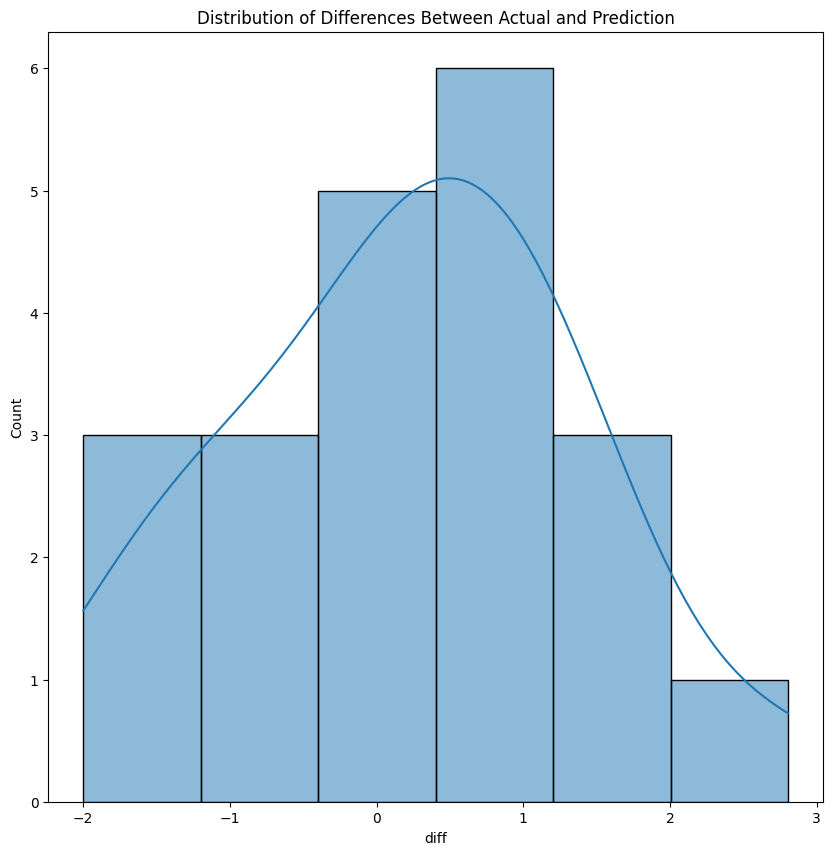

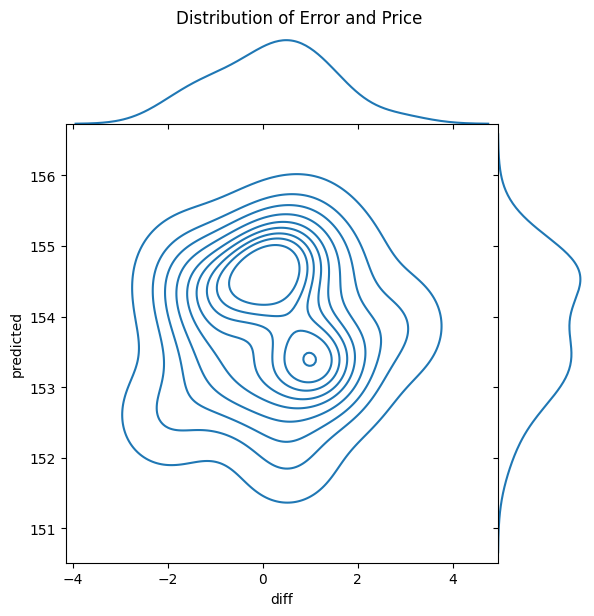

MSE :  1.3912346332688772
MAE :  0.9548252650669643
count    21.000000
mean      0.211898
std       1.188970
min      -1.998764
25%      -0.628021
50%       0.319656
75%       0.945999
max       2.804855
Name: diff, dtype: float64
Mean Percentage Error: 0.62%
Model Accuracy: 99.38%


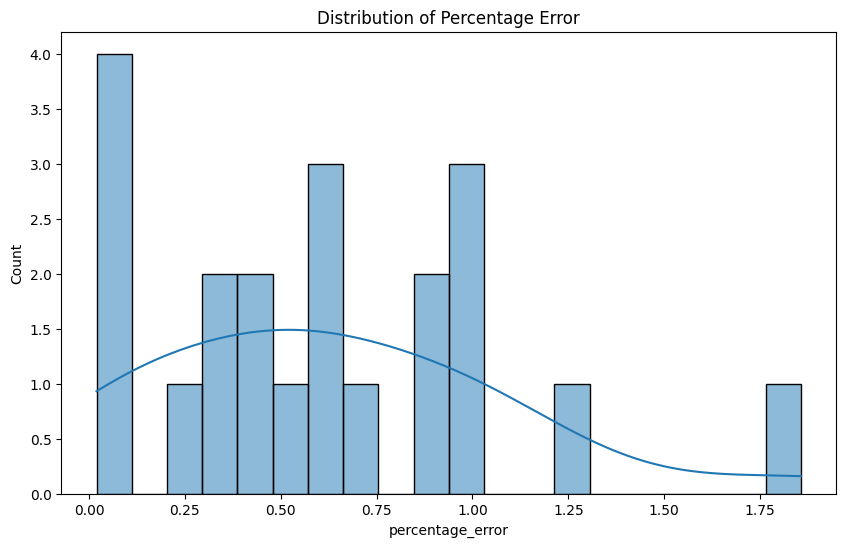

In [52]:
# Load the best model weights
model.load_weights("best_model_weights.keras")

# Make predictions
pred = model.predict(testX)
pred = y_scaler.inverse_transform(pred)  # Inverse scale predictions
close = y_scaler.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))  # Inverse scale actual values

# Prepare predictions DataFrame
predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['close'] = pd.Series(np.reshape(close, (close.shape[0])))

# Slice 'p' from df and ensure it has the correct datetime index
p = df[-pred.shape[0]:].copy()  # Slice the last rows to match the prediction shape
print(p.index)  # Verify it has the correct datetime index

# Assign 'p's index to predictions
predictions.index = p.index

# Ensure predictions contains the necessary columns
predictions = predictions.astype(float)
predictions = predictions.merge(p[['low', 'high']], right_index=True, left_index=True)

# Plotting
# Plot actual and predicted close prices with a red-blue scheme
ax = predictions['close'].plot(color='red', figsize=(40, 10), label='Actual Close')
predictions['predicted'].plot(color='blue', ax=ax, label='Predicted Close')
index = [str(item) for item in predictions.index]
# Fill the region between 'low' and 'high' values
plt.fill_between(x=index, y1=p['low'], y2=p['high'], alpha=0.4, label='Low-High Range')
plt.title('Prediction vs Actual (low and high as blue region)')
plt.legend()
plt.show()

# Other visualizations
# Add a new column for the difference between predicted and actual values
predictions['diff'] = predictions['predicted'] - predictions['close']

# Plot the distribution of differences
plt.figure(figsize=(10, 10))
sns.histplot(predictions['diff'], kde=True)
plt.title('Distribution of Differences Between Actual and Prediction')
plt.show()

# Plot a KDE distribution of error vs predicted prices
sns.jointplot(x="diff", y="predicted", data=predictions, kind="kde", space=0)
plt.suptitle('Distribution of Error and Price', y=1.02)
plt.show()

# Metrics
# Calculate and print MSE and MAE for model evaluation
print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['close'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['close'].values))
# Display descriptive statistics for the differences
print(predictions['diff'].describe())

# Calculate percentage error
predictions['percentage_error'] = (abs(predictions['predicted'] - predictions['close']) / predictions['close']) * 100

# Calculate mean percentage error
mean_percentage_error = predictions['percentage_error'].mean()

# Calculate accuracy (as 100% - mean percentage error)
accuracy = 100 - mean_percentage_error

# Print percentage error and accuracy
print(f"Mean Percentage Error: {mean_percentage_error:.2f}%")
print(f"Model Accuracy: {accuracy:.2f}%")

# Optional: Plot the distribution of percentage errors
plt.figure(figsize=(10, 6))
sns.histplot(predictions['percentage_error'], kde=True, bins=20)
plt.title('Distribution of Percentage Error')
plt.show()